In [1]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [2]:
# Read classes from file
def load_classes():
    """Load class information from classes.txt"""
    if not os.path.exists('classes.txt'):
        raise FileNotFoundError("classes.txt not found. Please ensure classes.txt is in the current directory.")
    
    labels = []
    names = []
    with open('classes.txt', 'r') as f:
        for line in f.readlines():
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                labels.append(int(parts[0]) - 1)  # Convert to 0-based indexing
                names.append(parts[1])
    
    classes_df = pd.DataFrame({
        'label': labels,
        'name': names
    })
    return classes_df

# Load classes
classes = load_classes()
print(f"Loaded {len(classes)} classes:")
for _, row in classes.iterrows():
    print(f"  {row['label']}: {row['name']}")
print()

Loaded 5 classes:
  -1:  rice leaf roller
  0:  rice leaf caterpillar
  1:  paddy stem maggot
  2:  asiatic rice borer
  3:  yellow rice borer



In [3]:
# Load dataset splits
def load_dataset_split(filepath):
    """Load dataset split from text file"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filepath} not found. Please ensure the file exists.")
    
    df = pd.read_csv(filepath, sep=' ', header=None, engine='python')
    df.columns = ['image_path', 'label']
    return df

# Load datasets
train_df = load_dataset_split('PlantYOLO/train.txt')
test_df = load_dataset_split('PlantYOLO/test.txt')
val_df = load_dataset_split('PlantYOLO/val.txt')

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")
print(f"\nClass distribution in training set:")
print(train_df['label'].value_counts().sort_index())
print(f"\nClass distribution in validation set:")
print(val_df['label'].value_counts().sort_index())
print(f"\nClass distribution in test set:")
print(test_df['label'].value_counts().sort_index())
print()

Train set: 2050 images
Validation set: 341 images
Test set: 1029 images

Class distribution in training set:
label
0    669
1    292
2    156
3    631
4    302
Name: count, dtype: int64

Class distribution in validation set:
label
0    111
1     48
2     26
3    106
4     50
Name: count, dtype: int64

Class distribution in test set:
label
0    335
1    147
2     79
3    316
4    152
Name: count, dtype: int64



In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define directory paths
TRAIN_DIR = "PlantYOLO/images/train"
VAL_DIR = "PlantYOLO/images/val"
TEST_DIR = "PlantYOLO/images/test"

# Check if directories exist
for dir_name, dir_path in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]:
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"{dir_name} directory not found: {dir_path}")
    print(f"{dir_name} directory: {dir_path} ({len(os.listdir(dir_path))} images)")

Using device: cuda
Train directory: PlantYOLO/images/train (2050 images)
Validation directory: PlantYOLO/images/val (341 images)
Test directory: PlantYOLO/images/test (5 images)


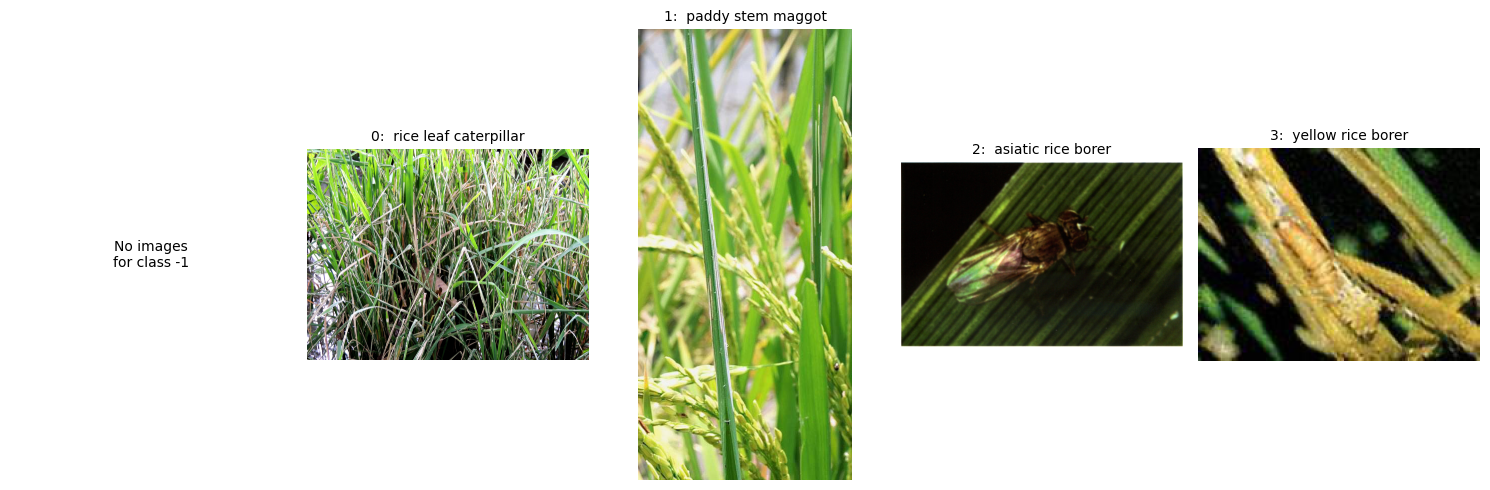

In [5]:
# Display sample images from each class
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
images = []

for i, (_, class_info) in enumerate(classes.iterrows()):
    class_label = class_info['label']
    class_name = class_info['name']
    
    # Find images for this class
    class_images = train_df[train_df.label == class_label].image_path.values
    if len(class_images) > 0:
        random_img = random.choice(class_images)
        img_path = os.path.join(TRAIN_DIR, random_img)
        
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            images.append(img)
            axs[i].imshow(img)
            axs[i].set_title(f"{class_label}: {class_name}", fontsize=10)
        else:
            images.append(np.zeros((224, 224, 3)))
            axs[i].text(0.5, 0.5, f"No image\nfor class {class_label}", 
                       ha='center', va='center', transform=axs[i].transAxes)
    else:
        images.append(np.zeros((224, 224, 3)))
        axs[i].text(0.5, 0.5, f"No images\nfor class {class_label}", 
                   ha='center', va='center', transform=axs[i].transAxes)
    
    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

In [6]:
class InsectModel(nn.Module):
    def __init__(self, num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    
    def forward(self, image):
        return self.model(image)

# Create model with correct number of classes
num_classes = 5
model = InsectModel(num_classes=num_classes)
model = model.to(device)
print(f"Created model with {num_classes} classes")

Created model with 5 classes


In [7]:
def train_transform():
    return A.Compose([
        A.HorizontalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(224, 224),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224, 224),
        ToTensorV2()])

In [8]:
class InsectDataset(Dataset):
    def __init__(self, image_df, image_dir, transforms=None):
        self.image_info = image_df.values
        self.transforms = transforms
        self.imgdir = image_dir
        
        # Validate image directory
        if not os.path.exists(self.imgdir):
            raise FileNotFoundError(f"Image directory not found: {self.imgdir}")
    
    def __len__(self):
        return len(self.image_info)
    
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image_path = os.path.join(self.imgdir, image_info[0])
        
        # Load and preprocess image
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
            
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        
        return image, label

In [9]:
# Create datasets and dataloaders
BATCH_SIZE = 32

train_dataset = InsectDataset(image_df=train_df, 
                              image_dir=TRAIN_DIR, 
                              transforms=train_transform())

val_dataset = InsectDataset(image_df=val_df,
                            image_dir=VAL_DIR,
                            transforms=valid_transform())

train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)

val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=0)

print(f"Created datasets with {len(train_dataset)} training and {len(val_dataset)} validation samples")

Created datasets with 2050 training and 341 validation samples


In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, loss, correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count

def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch+1}")
    
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(), correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc)
    
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader), desc=f"Validation {epoch+1}")
    
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking=True).float()
            labels = labels.to(device, non_blocking=True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc)
    
    return summary

In [11]:
# Training configuration
EPOCHS = 10
LR = 1e-4

def run_training():
    # Create model with correct number of classes
    model = InsectModel(num_classes=num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = float('inf')
    
    for epoch in range(EPOCHS):
        # Training
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        
        # Validation
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        
        # Save best model
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), 'vit_best.pth')
            print(f"Saved best model with validation loss: {best_loss:.5f}")
        
        print(f'Epoch {epoch+1:03d}: Train Loss: {train_loss.avg:.5f}, Train Acc: {train_loss.acc:.5f} | Val Loss: {val_loss.avg:.5f}, Val Acc: {val_loss.acc:.5f}')
    
    return model

# Uncomment to run training
# trained_model = run_training()

In [12]:
# Load best model for evaluation
if os.path.exists('vit_best.pth'):
    model = InsectModel(num_classes=num_classes)
    model.load_state_dict(torch.load('vit_best.pth', map_location=device))
    model = model.to(device)
    model.eval()
    print("Loaded best model for evaluation")
else:
    print("No trained model found. Please run training first.")
    model = None

RuntimeError: Error(s) in loading state_dict for InsectModel:
	size mismatch for model.head.weight: copying a param with shape torch.Size([102, 768]) from checkpoint, the shape in current model is torch.Size([5, 768]).
	size mismatch for model.head.bias: copying a param with shape torch.Size([102]) from checkpoint, the shape in current model is torch.Size([5]).

In [ ]:
# Test model on validation set
if model is not None:
    images, labels = next(iter(val_data_loader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.softmax(1).argmax(1)
    
    # Display results
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    
    for i in range(min(8, len(images))):
        row = i // 4
        col = i % 4
        
        # Convert image tensor to numpy for display
        img = images[i].cpu().permute(1, 2, 0).numpy()
        
        actual_label = classes.loc[classes['label'] == labels[i].item(), 'name'].values[0]
        pred_label = classes.loc[classes['label'] == preds[i].item(), 'name'].values[0]
        
        color = 'green' if labels[i].item() == preds[i].item() else 'red'
        
        axs[row, col].imshow(img)
        axs[row, col].set_title(f"Actual: {actual_label}\nPredicted: {pred_label}", color=color, fontsize=8)
        axs[row, col].set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy
    correct = (preds.cpu() == labels).sum().item()
    total = len(labels)
    accuracy = correct / total
    print(f"\nAccuracy on this batch: {correct}/{total} = {accuracy:.3f}")

In [ ]:
# Image upload and prediction interface
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def predict_image(image_path):
    """Predict the class of an uploaded image"""
    if model is None:
        print("No model loaded. Please train the model first.")
        return
    
    try:
        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img_resized = img.resize((224, 224))
        img_np = np.array(img_resized) / 255.0
        img_tensor = torch.tensor(img_np, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        
        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.softmax(1).argmax(1).item()
            confidence = output.softmax(1).max(1)[0].item()
        
        # Get predicted class name
        predicted_class = classes.loc[classes['label'] == pred, 'name'].values[0]
        
        # Display result
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.3f}", fontsize=14)
        plt.axis('off')
        plt.show()
        
        return predicted_class, confidence
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Create file upload widget
uploader = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False,
    description='Upload Image'
)

def on_upload_change(change):
    if uploader.value:
        # Get uploaded file info
        file_info = next(iter(uploader.value.values()))
        
        # Save uploaded file temporarily
        temp_path = f"temp_{file_info['metadata']['name']}"
        with open(temp_path, 'wb') as f:
            f.write(file_info['content'])
        
        # Make prediction
        print(f"Processing {file_info['metadata']['name']}...")
        predict_image(temp_path)
        
        # Clean up temp file
        if os.path.exists(temp_path):
            os.remove(temp_path)

uploader.observe(on_upload_change, names='value')

print("Upload an image to get predictions:")
display(uploader)